In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision.utils import make_grid
import time
import sys
import os
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import math

In [26]:
## If GPU is available, then the code will be pushed to it otherwise it will move to CPU 
use_cuda=torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [72]:
### Hyperparameters
batch_size=1
epochs=10
input_size=2 
num_layers=1
bd_flag=False
max_iter=10000
lossfn=0
hidden_state_size=5 ##TODO: tune it get better results
L=10


In [73]:
class LSTM(nn.Module):
    
    def __init__(self, input_size=input_size, hidden = hidden_state_size, number_of_layers= num_layers, bd_flag = bd_flag):
        super(LSTM,self).__init__()
        
        self.hidden=hidden
        
        self.bd_flag = bd_flag
        
        self.lstm=nn.LSTM(input_size = input_size, 
                          hidden_size = hidden, 
                          num_layers = number_of_layers,
                          bidirectional = bd_flag, 
                          batch_first = True)
        
        self.hidden_layer = nn.Linear(hidden + hidden*bd_flag ,1) #as size of the output is 1
        
        self.sigmoid = nn.Sigmoid()
        
        self.bd_flag = bd_flag
        self.hidden  = hidden
        
    def forward(self,x):
        
        ## Setting initial cell and hidden states
        h0 = torch.zeros(1+self.bd_flag, x.size(0), self.hidden).to(device) 
        c0 = torch.zeros(1+self.bd_flag, x.size(0), self.hidden).to(device)
        
        out,hidden_ = self.lstm(x,(h0,c0))
         
        
        prediction   = self.sigmoid(self.hidden_layer(out))
        
        return prediction

In [74]:
model=LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [75]:
def cross_entropy(pred, target): #custom cross entropy loss function as normal Pytorch doesn't support
    return (1/2)*(torch.mean(-torch.sum(target * torch.log(pred))) + torch.mean(-torch.sum((1-target) * torch.log(1-pred))))

In [76]:
train_loss_5=[]
train_acc_5=[]
train_loss_13=[]
train_acc_13=[]
train_loss_9=[]
train_acc_9=[]


test_loss_5=[]
test_acc_5=[]
test_loss_13=[]
test_acc_13=[]
test_loss_9=[]
test_acc_9=[]



In [77]:
def sequence_binary(stringLength):
  
        lowerBound=pow(2,stringLength-1)+1
        upperBound=pow(2,stringLength)

        num1=np.random.randint(lowerBound,upperBound)
        num2=np.random.randint(lowerBound,upperBound)
        
        num3=num1+num2
        

        
        num3Binary=(bin(num3)[2:])

        num1Binary=(bin(num1)[2:])

        num2Binary=(bin(num2)[2:])

        
        len_num1= (len(num1Binary))

        len_num2= (len(num2Binary))
        len_num3= (len(num3Binary))

        
        num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
        num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)


        x=np.zeros((len_num3,2),dtype=np.float32)
        for i in range(0, len_num3):
            x[i,0]=num1Binary[len_num3-1-i] # note that MSB of the binray string should be the last input along the time axis
            x[i,1]=num2Binary[len_num3-1-i]
        
        y=np.array(list(num3Binary), dtype=int)
        
        x=x[np.newaxis,:]
        y=y[np.newaxis,:]
    
        x = torch.tensor(x, dtype=torch.float)
        y = torch.tensor(y, dtype=torch.float)
        
        return x,y 

In [78]:
def train(model,optimizer,maxiter,train_loss,train_acc,lossfn):
    model.train()
    
    tloss=0
    acc=0
    
    for i in range(maxiter):
        
        x,y=sequence_binary(L)
        x=x.to(device)
        y=y.to(device)
        
    
        prediction= model(x)
        
        optimizer.zero_grad()
        
        if(lossfn==0):
            temp=np.squeeze(prediction,axis=2)
            #loss=cross_entropy
            lossval=cross_entropy(temp,y)
            
        if(lossfn==1):
            loss=nn.MSELoss()
            lossval=loss(prediction,y)
            
        lossval.backward()
        optimizer.step()
        
        tloss+=lossval.item()
        
        
        threshold = torch.Tensor([0.5]).to(device)
        predicted_y = (prediction > threshold).float() * 1
        
        predicted_y = predicted_y.detach().cpu().numpy()[:,0]
        predicted_y = predicted_y.dot(2**np.arange(predicted_y.shape[1]))

        y_10 = y.detach().cpu().numpy()
        y_10 = y_10.dot(2**np.arange(y_10.shape[1]))
        
        acc+=np.sum(predicted_y-y_10)
        
    train_loss.append(tloss/maxiter)
    train_acc.append(abs(acc)/maxiter)
        

In [79]:
def test(model,test_loss,test_acc):
    model.eval()
    
    tloss=0
    acc=0
    
    with torch.no_grad():
        
        for i in range(max_iter):
            
            x,y=sequence_binary(L)
            x=x.to(device)
            y=y.to(device)
            
            prediction= model(x)
            
            if(lossfn==0):
                temp=np.squeeze(prediction,axis=2)
                #loss=cross_entropy
                lossval=cross_entropy(temp,y)
            
            if(lossfn==1):
                loss=nn.MSELoss()
                lossval=loss(prediction,y)
                
            tloss+=lossval.item()
                
            threshold = torch.Tensor([0.5]).to(device)
            predicted_y = (prediction > threshold).float() * 1

            predicted_y = predicted_y.detach().cpu().numpy()[:,0]
            predicted_y = predicted_y.dot(2**np.arange(predicted_y.shape[1]))

            y_10 = y.detach().cpu().numpy()
            y_10 = y_10.dot(2**np.arange(y_10.shape[1]))
            
            acc+=np.sum(predicted_y-y_10)
            
    test_loss.append(tloss/max_iter)
    test_acc.append(abs(acc)/max_iter)
            

In [80]:
for epoch in range(epochs):
    train(model,optimizer,max_iter,train_loss_5,train_acc_5,lossfn=0)
    test(model,test_loss_5,test_acc_5)

In [81]:

def Check_binary_sequence(model,device,loss_flag = 0):
    
    model.eval()
    
    test_accuracies = []
    test_lossval = []
    
    for L in range(2,21): 
    
        
        test_loss    = 0
        test_correct = 0 
        test_length = 100
    
        
        with torch.no_grad():
            
            for i in range(100):
                    x,y = sequence_binary(L)

                    x=x.to(device)
                    y=y.to(device)



                    pred = model(x) 

                    if(loss_flag == 0): #CE Loss

                        temp=np.squeeze(pred,axis=2)
                       
                        lossval=cross_entropy(temp,y)
            

                    elif(loss_flag == 1):
                        lossfn=nn.MSELoss()
                        lossval=loss(prediction,y)


                    
                    threshold = torch.Tensor([0.5]).to(device) 
                    pred_y = (pred > threshold).float() * 1

                   
                    pred_y = pred_y.detach().cpu().numpy()[:,:,0]
                    pred_y = pred_y.dot(2**np.arange(pred_y.shape[1]))

                    y_10 = y.detach().cpu().numpy()
                    y_10 = y_10.dot(2**np.arange(y_10.shape[1]))

                   
                    test_loss    += lossval.item()
                    test_correct += np.sum(pred_y==y_10) 

           
            
            test_lossval.append(test_loss/test_length)

            test_correct /= test_length 

            test_accuracies.append(test_correct)

        
    sns.set_theme()
    plt.figure(figsize=(5, 5))

    plt.plot(np.arange(2,21),test_accuracies,color='r',marker='o')

    plt.xlabel("L values")
    plt.ylabel("Accuracy value")
    plt.title("Bit accuracy on 100 samples, trained with L=10")
    plt.grid(True)



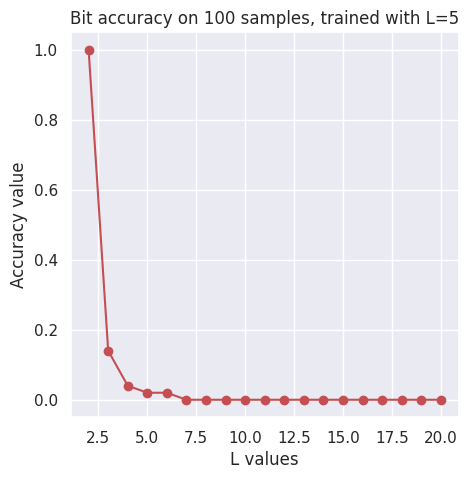

In [57]:
Check_binary_sequence(model,device,loss_flag = 0)

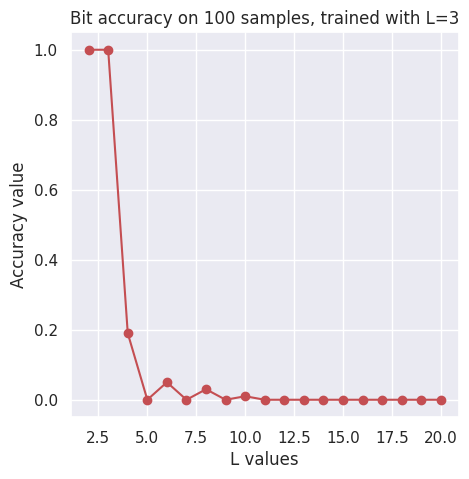

In [71]:
Check_binary_sequence(model,device,loss_flag = 0)

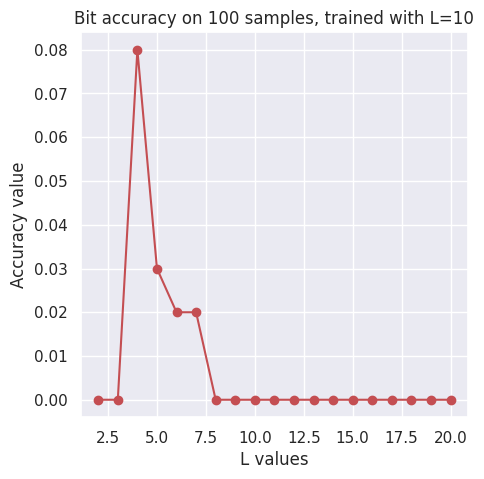

In [86]:
Check_binary_sequence(model,device,loss_flag = 0)